In [413]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [492]:
df=pd.read_csv('data/data_BNB-USD.csv')
df['ret']=(np.log(df.Close)-np.log(df.Close.shift(1))).shift(-1)
df['Y']=df.ret
df.Y[df.Y>0]=1
df.Y[df.Y<=0]=0
df=df.dropna()

In [493]:
df

,Time,Open,High,Low,Close,Volume,ret,Y
0,2021-12-25 00:00:00,543.030,543.291,541.401,542.039,270197.66673,0.000780,1.0
1,2021-12-25 00:05:00,542.039,542.718,542.001,542.462,174088.55210,-0.004940,0.0
2,2021-12-25 00:10:00,542.462,542.462,537.266,539.789,806500.30023,0.003032,1.0
3,2021-12-25 00:15:00,539.764,541.428,538.859,541.428,230081.83941,0.001427,1.0
4,2021-12-25 00:20:00,541.428,542.400,541.055,542.201,118458.15933,-0.000077,0.0
...,...,...,...,...,...,...,...,...
2586,2022-01-02 23:30:00,530.612,530.982,530.548,530.938,20882.72443,0.000491,1.0
2587,2022-01-02 23:35:00,530.938,531.335,530.907,531.199,76117.09294,0.000755,1.0
2588,2022-01-02 23:40:00,531.199,531.600,531.199,531.600,41987.63182,-0.000828,0.0
2589,2022-01-02 23:45:00,531.600,531.719,531.068,531.160,90641.89743,0.000294,1.0


In [494]:
lookback_windows=12
label_ls=[]
for label in ['Open','High','Low','Close','Volume']:
    for l in range(1,lookback_windows+1):
        df[f'{label}_{l}']=df[f'{label}'].shift(l)
        label_ls.append(f'{label}_{l}')
df=df.dropna()

In [495]:
X=df[['Open','High','Low','Close','Volume']+label_ls]
X=X/X.iloc[0]
y=df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=0)

In [496]:
clf = LogisticRegression().fit(X_train, y_train)


In [497]:
mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10),(15),(20),(20,5),(15,5)],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [10, 15, 20, (20, 5), (15, 5)]})

In [498]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'hidden_layer_sizes': 10}


In [499]:
y_pred=clf.predict(X_test)

In [500]:
precision_recall_fscore_support(y_test, y_pred,average='binary')

(0.516245487364621, 0.5181159420289855, 0.5171790235081374, None)

0.5206521739130435


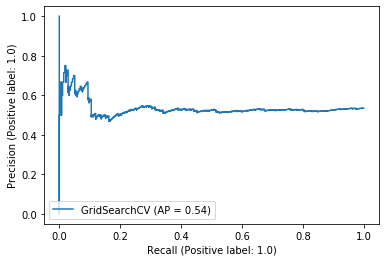

In [501]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,0], pos_label=1)
print(metrics.auc(fpr, tpr))

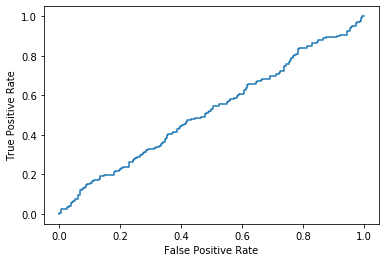

In [502]:
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [503]:
#backtesting
df_pred=df.iloc[:len(y_pred)]
df_pred['pred']=y_pred

In [504]:
df_pred=df_pred[['ret','Y','pred']]
df_pred

,ret,Y,pred
12,0.002789,1.0,1.0
13,0.000905,1.0,1.0
14,0.000928,1.0,1.0
15,0.001168,1.0,1.0
16,0.000309,1.0,1.0
...,...,...,...
523,-0.000440,0.0,1.0
524,-0.000892,0.0,1.0
525,-0.001546,0.0,0.0
526,0.002569,1.0,1.0


In [505]:
df_pred=df_pred[df_pred.pred==1]

In [506]:
df_pred[['ret','Y','pred']]

,ret,Y,pred
12,0.002789,1.0,1.0
13,0.000905,1.0,1.0
14,0.000928,1.0,1.0
15,0.001168,1.0,1.0
16,0.000309,1.0,1.0
...,...,...,...
521,0.000033,1.0,1.0
523,-0.000440,0.0,1.0
524,-0.000892,0.0,1.0
526,0.002569,1.0,1.0


In [507]:
df_pred['pnl']=df_pred.ret.cumsum()

In [508]:
df_pred

,ret,Y,pred,pnl
12,0.002789,1.0,1.0,0.002789
13,0.000905,1.0,1.0,0.003694
14,0.000928,1.0,1.0,0.004621
15,0.001168,1.0,1.0,0.005789
16,0.000309,1.0,1.0,0.006098
...,...,...,...,...
521,0.000033,1.0,1.0,-0.008856
523,-0.000440,0.0,1.0,-0.009296
524,-0.000892,0.0,1.0,-0.010188
526,0.002569,1.0,1.0,-0.007619


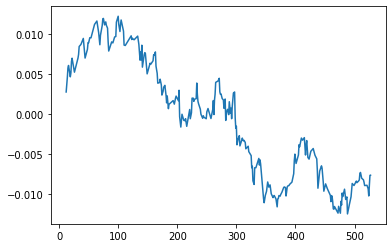

In [509]:
df_pred.pnl.plot()

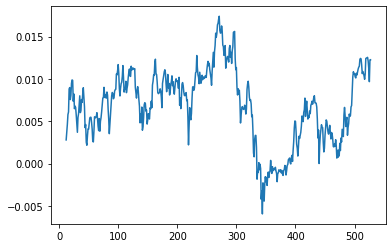

In [512]:
df['pnl']=df.ret.cumsum()
df.iloc[:len(y_pred)].pnl.plot()